In [1]:
import torch
import torchmin.bfgs as bfs
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torchmin.benchmarks as bm
from opti_utils import BFGS,strong_wolfe,f,logistic
import torchmin.minimize as minimize
import os
from torch.utils.data import DataLoader,Dataset
import time
from torchmin.line_search import strong_wolfe as SW

## define size and other hyperparameter

In [2]:
batchsize=64
m=500
n=100
DIM=n
num_class=62
batch=100
epoch=10

In [3]:
USE_CUDA=False
if torch.cuda.is_available():
    USE_CUDA=True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA

True

## Data import and implement dataset

In [4]:
def generate_samples(path_baseb, pathsample,num_class=62,n=100, m=500, num_samples_to_generate=64000):
    if not os.path.exists(pathsample):
        os.mkdir(pathsample)
    
    
    for i in tqdm(range(num_samples_to_generate)):
        selected_classes = np.random.choice(range(num_class), size=2, replace=False)
        stand = selected_classes[0]
        
        A = torch.empty(0,)
        for class_id in selected_classes:
            path = os.path.join(path_baseb, str(class_id))
            indices = np.random.choice(os.listdir(path), size=m // 2, replace=False)
            sample = torch.empty(0,)
            sign = 0
            for item in indices:
                if class_id == stand:
                    sign = 1
                else:
                    sign = 0
                tmp = torch.load(os.path.join(path, str(item)))
                tmp = tmp.reshape((1, -1))
                idc = torch.tensor(sign)
                tmp = torch.cat((tmp, idc.unsqueeze(0).unsqueeze(0)), dim=1)
                sample = torch.cat((sample, tmp), dim=0)
            A = torch.cat((A, sample))
        
        A_numpy = A.numpy()
        np.random.shuffle(A_numpy)
        shuffled_A = torch.from_numpy(A_numpy)
        torch.save(shuffled_A, os.path.join(pathsample, str(i)))
path_baseb = 'data_balanced'
pathsample = 'sample'
num_samples_to_generate = batch * batchsize * epoch
#generate_samples(path_baseb,pathsample,n=n,m=m,num_samples_to_generate=num_samples_to_generate)

In [5]:
path_baseb='sample'
class LRDataset(Dataset):
    def __init__(self, data_folder,num):
        self.data_A = []
        self.data_B = []
        files = os.listdir(data_folder)
        count=0
        for file in files:
            count+=1
            if count>num:
                break
            file_path = os.path.join(data_folder, file)
            # 假设数据是使用 torch.save 存储的
            data = torch.load(file_path)
            A_part = data[:, :-1]  # Assuming A is all columns except the last one
            B_part = data[:, -1]   # Assuming B is the last column
            self.data_A.append(A_part)
            self.data_B.append(B_part)
    
    def __len__(self):
        # 确保至少一个部分数据不为空
        return len(self.data_A) if self.data_A else len(self.data_B) if self.data_B else 0
    
    def __getitem__(self, idx):
        return self.data_A[idx], self.data_B[idx]
num_generate=batch*batchsize
LR_Data =LRDataset(path_baseb,num_generate)

In [6]:
data_loader = DataLoader(LR_Data, batch_size=batchsize, shuffle=True)

In [7]:
first_batch = next(iter(data_loader))
batch_data_A,batch_data_B=first_batch

In [8]:
starttime=time.time()
x0 = torch.randn((1,n),device=device,requires_grad=True)
batch_data_A = batch_data_A.to(device)[0].unsqueeze(0)
batch_data_B = batch_data_B.to(device)[0].unsqueeze(0)
BFGS_loss=run_bfgs(batch_data_A,batch_data_B,x0,batchsize,n,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.7)
endtime=time.time()

NameError: name 'run_bfgs' is not defined

## BFGS

200


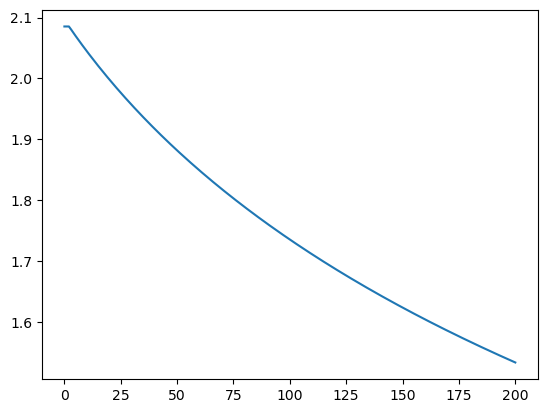

In [ ]:
W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
Y = torch.rand((batchsize,DIM),device=device)
x = torch.ones((batchsize,DIM),device=device,requires_grad=True)

steps=200
B=BFGS(batchsize,DIM,device,x)
mem_loss=[]
loss=logistic(W,Y,x,2,DIM)
acc=1e-6
mem_loss.append(loss.mean())
g=torch.autograd.grad(loss.mean(),x)[0]
d=-torch.matmul(B.H,g.unsqueeze(2))
k=0
#print(loss)
for i in range(steps):
    g_pre=g
    alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
    update=alpha*(d.squeeze())
    x=x+update
    loss=logistic(W,Y,x,2,DIM)
    mem_loss.append(loss.mean())
    g=torch.autograd.grad(loss.mean(),x)[0]
    #print(torch.norm(g,dim=1).mean())
    if(sum(torch.norm(g,dim=1)<acc)>0):
        break
    d=-torch.matmul(B.H,g.unsqueeze(2))
    #print(B.H)
    B.H_BFDS_update(update,g-g_pre)
    k+=1
    
print(k)    
plt.plot([i.cpu().detach().numpy() for i in mem_loss])  

## LSTM define

In [ ]:
class LSTM_motify(torch.nn.Module):
    """LSTM修正器
       LSTM optimizer"""
    
    def __init__(self,input_size,output_size, hidden_size, num_stacks, batchsize,p  = 10 ,preprocess = True, output_scale = 1):
        super(LSTM_motify,self).__init__()
        self.preprocess_flag = preprocess
        self.input_flag = 2
        if preprocess != True:
             self.input_flag = 1
        self.p = p
        self.output_scale = output_scale 
        self.lstm = torch.nn.LSTM(input_size*self.input_flag, hidden_size, num_stacks)
        self.Linear = torch.nn.Linear(hidden_size,output_size) #1-> output_size
        print(self.preprocess_flag)
        
    def LogAndSign_Preprocess_Gradient(self,gradients):
        """
        Args:
          gradients: `Tensor` of gradients with shape `[d_1, ..., d_n]`.
          p       : `p` > 0 is a parameter controlling how small gradients are disregarded 
        Returns:
          `Tensor` with shape `[d_1, ..., d_n-1, 2 * d_n]`. The first `d_n` elements
          along the nth dimension correspond to the `log output` \in [-1,1] and the remaining
          `d_n` elements to the `sign output`.
        """
        p  = self.p
        log = torch.log(torch.abs(gradients))
        clamp_log = torch.clamp(log/p , min = -1.0,max = 1.0)
        clamp_sign = torch.clamp(torch.exp(torch.tensor(p))*gradients, min = -1.0, max =1.0)
        return torch.cat((clamp_log,clamp_sign),dim = -1) #在gradients的最后一维input_dims拼接
    
    def Output_motification_And_motify_LSTM_Hidden_State(self, input_gradients, prev_state):
        """LSTM的核心操作  core operation
        coordinate-wise LSTM """
        if prev_state is None: #init_state
            prev_state = (torch.zeros(Layers,batchsize,Hidden_nums),
                            torch.zeros(Layers,batchsize,Hidden_nums))
            if USE_CUDA :
                 prev_state = (torch.zeros(Layers,batchsize,Hidden_nums).cuda(),
                            torch.zeros(Layers,batchsize,Hidden_nums).cuda())
         			
        motify , next_state = self.lstm(input_gradients, prev_state)
        motify = self.Linear(motify) * self.output_scale # transform the LSTM output to the target output dim 
        return motify, next_state
    
    def forward(self,input_data, prev_state):
        if USE_CUDA:
            input_data = input_data.cuda()
        #pytorch requires the `torch.nn.lstm`'s input as（1，batchsize,input_dim）
        # original gradient.size()=torch.size[5] ->[1,1,5]
        # gradients = move_gradients.unsqueeze(0)
        # moves = move.unsqueeze(0)
        # combined = torch.cat((moves, gradients), dim=0)
        if self.preprocess_flag == True:
            #print(input_data.shape)
            input_data = self.LogAndSign_Preprocess_Gradient(input_data)
        motify , next_state = self.Output_motification_And_motify_LSTM_Hidden_State(input_data , prev_state)
        # Squeeze to make it a single batch again.[1,1,5]->[5]
        motify = motify.squeeze().squeeze()
       
        return motify , next_state

In [ ]:
Layers = 2
Hidden_nums = 20
Input_DIM = DIM*2
Output_DIM = DIM**2
output_scale_value=1

#######   构造一个优化器  #######
#######  construct a optimizer  #######
LSTM_motify = LSTM_motify(Input_DIM, Output_DIM, Hidden_nums ,Layers , batchsize=batchsize,\
                preprocess=False,output_scale=output_scale_value)
print(LSTM_motify)

if USE_CUDA:
    LSTM_optimizer = LSTM_motify.cuda()

False
LSTM_motify(
  (lstm): LSTM(200, 20, num_layers=2)
  (Linear): Linear(in_features=20, out_features=10000, bias=True)
)


## LSTM pre-train vs BFGS

In [ ]:
import time

In [ ]:
def record(loss,standard='mean',num=0):
    if standard=='mean':
        return loss.mean()
    else:
        return loss[num]

In [ ]:
def LSTM_iter(W,Y,x,batchsize,DIM,device,standard='mean',rec_num=0,steps=200,acc=1e-6,plot=False,lam=2, max_iter=10):    
    start_time=time.time()
    state=None#初始化LSTM hidden state
    H=torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
    mem_loss=[]#初始化loss的list
    loss=logistic(W,Y,x,lam,DIM)#每个case的loss
    global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
    lossmean=loss.mean()#总loss的平均值

    global_loss_graph+=lossmean
    mem_loss.append(loss[rec_num])

    lossmean.backward(retain_graph=True)
    g = x.grad.clone()#g detach掉
    d=-torch.matmul(H,g.unsqueeze(2))
    k=0
    #print(loss)
    for i in range(steps):
        g_pre=g.clone()# 保存g作为上一次的g，此时g_pre不在计算图中
        alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
        alpha.detach_()
        #print(alpha)
        update=alpha*d.squeeze(-1)
        # update=d.squeeze()
        x=x+update
        x.retain_grad()
        loss=logistic(W,Y,x,lam,DIM)
        lossmean=loss.mean()
        global_loss_graph+=lossmean
        mem_loss.append(loss[rec_num])
        #print(mem_loss[0])
        lossmean.backward(retain_graph=True)
        #print([i.grad for i in LSTM_motify.parameters()])
        #print(g)
        g = x.grad.clone()
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0 or torch.isnan(lossmean).item()==True):
            break
        #print(B.H)
        input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
        #print(input_vec.is_leaf)
        motify,state=LSTM_motify(input_vec,state)
        deltaH=motify.reshape((batchsize, DIM, DIM))
        H = H.clone().detach() + deltaH*deltaH.transpose(1, 2)
        H.retain_grad()
        d=-torch.matmul(H,g.unsqueeze(2))
        k+=1
    if plot:
        plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM')
        end_time = time.time()
        LSTM_time = end_time - start_time
    return mem_loss,global_loss_graph,LSTM_time

In [ ]:
def BFGS_iter(W,Y,x,batchsize,DIM,device,standard='mean',rec_num=0,steps=200,acc=1e-6,plot=False,lam=2):
    start_time=time.time()
    B=BFGS(batchsize,DIM,device,x)
    mem_loss=[]
    loss=logistic(W,Y,x,lam,DIM)
    acc=1e-6
    global_loss=0
    lossmean=loss.mean()
    global_loss+=lossmean
    mem_loss.append(loss[rec_num])
    g=torch.autograd.grad(loss.mean(),x)[0]
    d=-torch.matmul(B.H,g.unsqueeze(2))
    k=0
    #print(loss)
    for i in range(steps):
        g_pre=g
        alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=1000,device=device)
        update=alpha*(d.squeeze())
        x=x+update
        loss=logistic(W,Y,x,lam,DIM)
        lossmean=loss.mean()
        global_loss+=lossmean
        mem_loss.append(loss[rec_num])
        g=torch.autograd.grad(lossmean,x)[0]
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0 or torch.isnan(lossmean).item()==True):
            break
        d=-torch.matmul(B.H,g.unsqueeze(2))
        #print(B.H)
        B.H_BFDS_update(update,g-g_pre)
        k+=1

    end_time = time.time()
    BFGS_time = end_time - start_time
    if plot:
        plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='BFGS')  
    return mem_loss,global_loss,BFGS_time

In [ ]:
def gradient_iter(W,Y,x,batchsize,DIM,device,standard='mean',rec_num=0,step=50,acc=1e-6,plot=False):    
    start_time=time.time()
    mem_loss=[]#初始化loss的list
    loss=f(W,Y,x)#每个case的loss
    global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
    lossmean=loss.mean()#总loss的平均值

    global_loss_graph+=lossmean
    mem_loss.append(loss[rec_num])

    lossmean.backward(retain_graph=True)
    g = x.grad
    k=0
    #print(loss)
    for i in range(steps):
        # update=d.squeeze()
        x=x-g
        x.retain_grad()
        loss=f(W,Y,x)
        lossmean=loss.mean()
        global_loss_graph+=lossmean
        mem_loss.append(loss[rec_num])
        #print(mem_loss[0])
        lossmean.backward(retain_graph=True)
        #print([i.grad for i in LSTM_motify.parameters()])
        #print(g)
        g = x.grad
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0):
            break
        #print(B.H)
        #print(input_vec.is_leaf)
        k+=1
    if plot:
        plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='Gradient')
        end_time = time.time()
        LSTM_time = end_time - start_time
    return mem_loss,global_loss_graph,LSTM_time

In [ ]:
def run_bfgs(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.7):
    if USE_CUDA:
        W = W.cuda()
        Y = Y.cuda()
        x = x.cuda()
    def logistic(A,b,x,lamb,n):
        sig=torch.sigmoid(torch.matmul(A,x.unsqueeze(-1)).squeeze())
        return -(b*torch.log(sig)+(1-b)*torch.log(1-sig)).mean(dim=1)+lamb/n*torch.norm(x,dim=-1)
    def fun(x):
        x.unsqueeze(0)
        return logistic(W,Y,x,lam,DIM).mean()

    result=minimize(fun,x.squeeze(),method='bfgs',return_all=True,disp=1)
    result['allvecs'][0]=x
    if plot:
        plt.plot([fun(i).cpu().detach().numpy() for i in result['allvecs']],label='BFGS_imple')
    return [fun(i) for i in result['allvecs']],result['allvecs']


Desired error not necessarily achieved due to precision loss.
         Current function value: nan
         Iterations: 1
         Function evaluations: 27
BFGS_time 0.10964465141296387
lstm_time 0.01600027084350586


[tensor(inf, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(nan, device='cuda:0', grad_fn=<SelectBackward0>)]

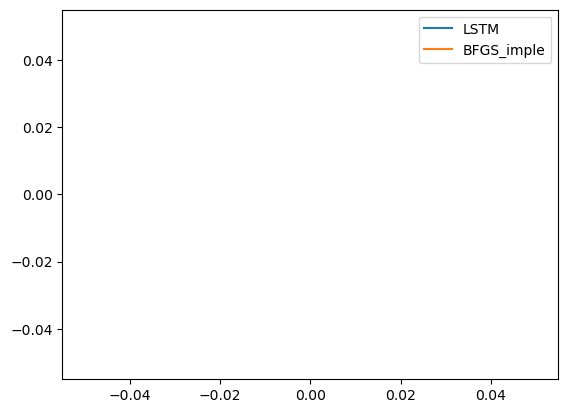

In [ ]:
# batchsize=1
# W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
# Y = torch.rand((batchsize,DIM),device=device)
# x0 = torch.randn((batchsize,DIM),device=device,requires_grad=True)
# x=x0.clone().detach_()
# x.requires_grad_(True)
# #bfgs_loss,bfgs_tot_loss,bfgs_time=BFGS_iter(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.7)
# x=x0.clone().detach_()
# x.requires_grad_(True)
# lstm_loss,lstm_tot_loss,lstm_time=LSTM_iter(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.7,steps=15)
# x = torch.ones((batchsize,DIM),device=device,requires_grad=True)
# starttime=time.time()
# BFGS_loss=run_bfgs(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.7)
# endtime=time.time()
# BFGS_time=endtime-starttime
# print('BFGS_time',BFGS_time)
# print('lstm_time',lstm_time)
# #grad_loss,grad_tot_loss,grad_time=gradient_iter(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True)
# plt.legend()
# lstm_loss

torch.Size([1, 500, 100]) torch.Size([1, 500])
Optimization terminated successfully.
         Current function value: 0.029585
         Iterations: 87
         Function evaluations: 89


tensor([ 3.8501e-05,  3.2798e-02,  1.2319e-01,  2.9174e-02, -2.5123e-01,
        -7.3083e-01, -4.9432e-01, -3.0964e-01, -9.8711e-02, -3.1932e-02,
         6.7518e-02,  9.1354e-01,  1.4784e+00,  2.7226e-01, -1.0065e+00,
        -1.4405e+00, -5.2899e-02,  4.1294e-01, -2.2376e-01, -8.1640e-02,
         8.9179e-02,  1.2521e+00,  1.5806e+00,  6.9646e-01, -3.3288e-01,
         1.5107e+00,  1.6007e+00, -9.3505e-01, -1.4381e+00, -2.2575e-01,
        -2.3173e-01, -5.1652e-01,  1.5646e+00,  1.9763e+00,  1.5324e+00,
         1.8705e+00,  9.4363e-01, -1.4235e+00, -2.3832e+00, -5.8428e-01,
        -3.9598e-01, -1.3619e-01,  8.4396e-01,  1.2138e+00,  1.2346e+00,
         1.8864e+00, -1.5682e+00, -1.8400e+00, -1.2230e+00, -4.1612e-01,
         1.3908e-01,  4.5916e-02,  2.6464e-01,  6.4781e-01,  5.9389e-01,
        -4.5098e-01, -2.9487e+00, -1.6429e+00, -1.8332e+00, -5.1695e-01,
        -2.6950e-01, -6.8137e-01,  5.3462e-01,  1.1523e+00, -8.9839e-01,
        -3.0633e+00, -1.7372e+00, -1.0015e+00, -1.4

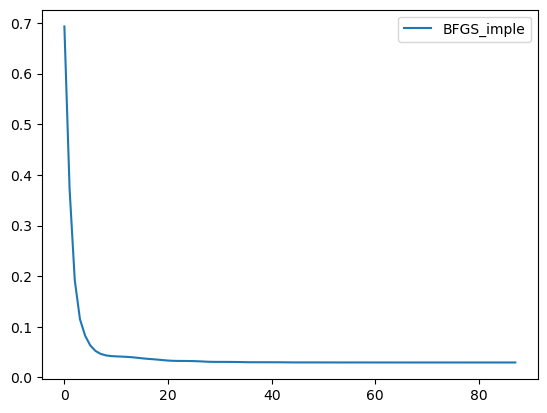

In [ ]:
# A,B=next(iter(data_loader))
# starttime=time.time()
# x0 = torch.zeros((1,n),device=device,requires_grad=True)
# batch_data_A = A.to(device)[0].unsqueeze(0)
# batch_data_B = B.to(device)[0].unsqueeze(0)
# print(batch_data_A.shape,batch_data_B.shape)
# BFGS_loss,a=run_bfgs(batch_data_A,batch_data_B,x0,batchsize,n,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.2)
# #lstm_loss,lstm_tot_loss,lstm_time=LSTM_iter(batch_data_A,batch_data_B,x0,batchsize,n,device,standard='mean',acc=1e-6,plot=True,lam=0.1)
# endtime=time.time()
# plt.legend()
# BFGS_loss[-1]
# a[-1]

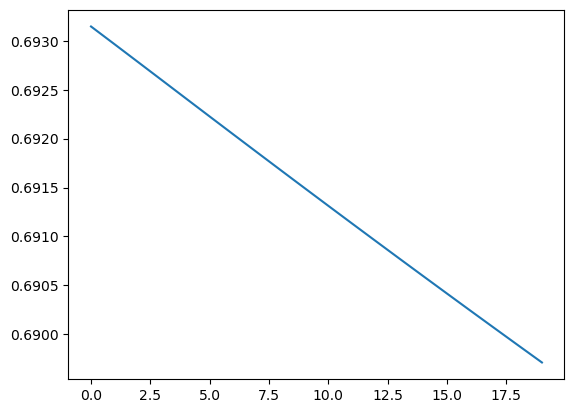

In [ ]:
plt.plot([i.cpu().detach().numpy() for i in lstm_loss[0:20]])

## Train LSTM

In [ ]:
def RUN(W,Y,x,batchsize,DIM,steps=40,lam=0.5,reset=True,acc=1e-6):
    if reset:
        x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)
    x.requires_grad=True
    state=None#初始化LSTM hidden state
    H=torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
    mem_loss=[]#初始化loss的list
    loss=logistic(W,Y,x,lam,DIM)#每个case的loss
    global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
    lossmean=loss.mean()#总loss的平均值

    global_loss_graph+=lossmean
    mem_loss.append(lossmean.clone().detach())
    lossmean.backward(retain_graph=True)
    g = x.grad.clone()#g detach掉
    d=-torch.matmul(H,g.unsqueeze(2))
    k=0
    #print(loss)
    for i in range(steps):
        g_pre=g.clone()# 保存g作为上一次的g，此时g_pre不在计算图中
        alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
        alpha.detach_()
        update=alpha*d.squeeze()
        #update=d.squeeze(-1)
        x=x+update
        x.retain_grad()
        loss=logistic(W,Y,x,lam,DIM)
        lossmean=loss.mean()
        global_loss_graph+=lossmean
        mem_loss.append(lossmean.clone().detach())
        #print(mem_loss[0])
        lossmean.backward(retain_graph=True)
        #print([i.grad for i in LSTM_motify.parameters()])
        #print(g)
        g = x.grad.clone()
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0):
            break
        #print(B.H)
        input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
        #print(input_vec.is_leaf)
        motify,state=LSTM_motify(input_vec,state)
        deltaH=motify.reshape((batchsize, DIM, DIM))
        H = H.clone().detach() + deltaH*deltaH.transpose(1, 2)
        H.retain_grad()
        d=-torch.matmul(H,g.unsqueeze(2))
        k+=1
    plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM_before_train')

    return mem_loss,global_loss_graph,x

In [ ]:
def global_training(epoch,batch,DIM,substeps,eachsteps,motifier,device,batchsize=128):
    global_loss_list = []    
    adam_global_optimizer = torch.optim.Adam(motifier.parameters(),lr = 0.0001)
    # W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
    # Y = torch.rand((batchsize,DIM),device=device)
    data_loader = DataLoader(LR_Data, batch_size=batchsize, shuffle=True)
    # x = torch.ones((batchsize,DIM),device=device,requires_grad=True)
    # _,global_loss_1,x = RUN(W,Y,x,batchsize,DIM,steps=eachsteps)
    # print(global_loss_1)
    for i in range(epoch):

        print(f'epoch {i}:')
        for A,b in tqdm(data_loader):
            A=A.to(device)
            #print(A.device)
            b=b.to(device)
            subiterloss=0
            for j in range(substeps):
                x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)
                resetflag=(j==0)
                
                _,global_loss,x = RUN(A,b,x.clone().detach(),batchsize,DIM,steps=eachsteps,reset=resetflag)
                subiterloss+=global_loss
                adam_global_optimizer.zero_grad()
                global_loss.backward() #每次都是优化这个固定的图，不可以释放动态图的缓存
                #print('xxx',[z.shape for z in motifier.parameters()  ])
                adam_global_optimizer.step()
                if torch.isnan(subiterloss):
                    raise ValueError("NaN value")
            global_loss_list.append(global_loss.detach_())
        
    print(global_loss)

epoch 0:


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


epoch 1:


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


epoch 2:


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


epoch 3:


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


epoch 4:


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


epoch 5:


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


epoch 6:


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


epoch 7:


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


epoch 8:


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


epoch 9:


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


epoch 10:


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


epoch 11:


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


epoch 12:


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


epoch 13:


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


epoch 14:


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


epoch 15:


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


epoch 16:


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


epoch 17:


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


epoch 18:


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


epoch 19:


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


tensor(13.7962, device='cuda:0')


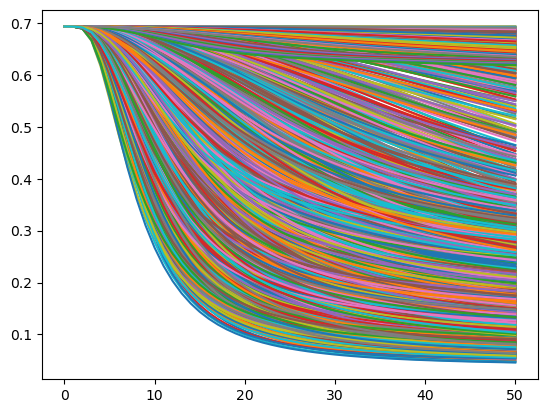

In [ ]:
global_training(epoch*2,batch,n,1,50,LSTM_motify,device=device,batchsize=batchsize)

# Evaluate

torch.Size([1, 500, 100]) torch.Size([1, 500])
Optimization terminated successfully.
         Current function value: 0.131365
         Iterations: 68
         Function evaluations: 69


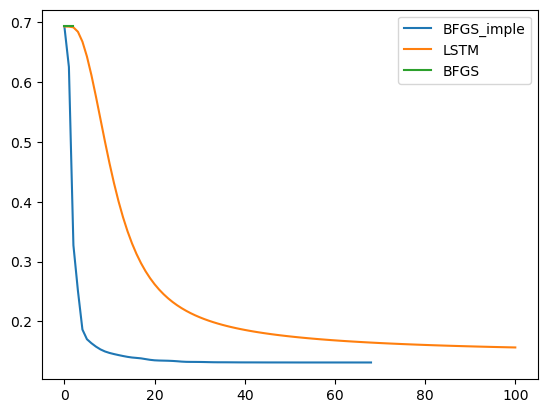

In [ ]:
A,B=next(iter(data_loader))
starttime=time.time()
x0 = torch.zeros((1,n),device=device,requires_grad=True)
batch_data_A = A.to(device)[0].unsqueeze(0)
batch_data_B = B.to(device)[0].unsqueeze(0)
print(batch_data_A.shape,batch_data_B.shape)
BFGS_loss,a=run_bfgs(batch_data_A,batch_data_B,x0,batchsize,n,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.7)
lstm_loss,lstm_tot_loss,lstm_time=LSTM_iter(batch_data_A,batch_data_B,x0,batchsize,n,device,standard='mean',acc=1e-6,plot=True,lam=0.7,steps=100,max_iter=20)
BFGS_iter(batch_data_A,batch_data_B,x0,batchsize,n,device,standard='mean',acc=1e-6,plot=True,lam=0.7)
endtime=time.time()
plt.legend()

In [ ]:
def fun

In [ ]:
def LSTM_iter(W,Y,x,batchsize,DIM,device,standard='mean',rec_num=0,steps=200,acc=1e-6,plot=False,lam=2):    
    start_time=time.time()
    state=None#初始化LSTM hidden state
    H=torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
    mem_loss=[]#初始化loss的list
    loss=logistic(W,Y,x,lam,DIM)#每个case的loss
    global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
    lossmean=loss.mean()#总loss的平均值

    global_loss_graph+=lossmean
    mem_loss.append(loss[rec_num])

    lossmean.backward(retain_graph=True)
    g = x.grad.clone()#g detach掉
    d=-torch.matmul(H,g.unsqueeze(2))
    k=0
    #print(loss)
    for i in range(steps):
        g_pre=g.clone()# 保存g作为上一次的g，此时g_pre不在计算图中
        alpha=SW(fun=f,x,1,d,g,)
        alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
        alpha.detach_()
        #print(alpha)
        update=alpha*d.squeeze(-1)
        # update=d.squeeze()
        x=x+update
        x.retain_grad()
        loss=logistic(W,Y,x,lam,DIM)
        lossmean=loss.mean()
        global_loss_graph+=lossmean
        mem_loss.append(loss[rec_num])
        #print(mem_loss[0])
        lossmean.backward(retain_graph=True)
        #print([i.grad for i in LSTM_motify.parameters()])
        #print(g)
        g = x.grad.clone()
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0 or torch.isnan(lossmean).item()==True):
            break
        #print(B.H)
        input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
        #print(input_vec.is_leaf)
        motify,state=LSTM_motify(input_vec,state)
        deltaH=motify.reshape((batchsize, DIM, DIM))
        H = H.clone().detach() + deltaH*deltaH.transpose(1, 2)
        H.retain_grad()
        d=-torch.matmul(H,g.unsqueeze(2))
        k+=1
    if plot:
        plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM')
        end_time = time.time()
        LSTM_time = end_time - start_time
    return mem_loss,global_loss_graph,LSTM_time